In [45]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch.nn.utils.spectral_norm as spectral_norm
from scipy.spatial.distance import pdist, squareform

# Set random seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

class Config:
    SEED = 42
    WINDOW_SIZE = 12  # Adjust based on data frequency
    BATCH_SIZE = 32
    EPOCHS = 50
    PATIENCE = 10
    LEARNING_RATE = 0.001
    FEATURE_DIM = 2  # Latitude, Longitude
    HIDDEN_DIM = 64
    NUM_HEADS = 4
    DROPOUT = 0.2

config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [46]:
class MultiHeadGraphConvolution(nn.Module):
    """Multi-head graph convolution with attention mechanism"""
    def __init__(self, in_features, out_features, num_heads=4, dropout=0.1):
        super(MultiHeadGraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_heads = num_heads
        self.head_dim = out_features // num_heads

        assert out_features % num_heads == 0, "out_features must be divisible by num_heads"

        # Multi-head linear transformations
        self.W_heads = nn.ModuleList([
            nn.Linear(in_features, self.head_dim) for _ in range(num_heads)
        ])

        # Attention mechanism for heads
        self.attention = nn.MultiheadAttention(out_features, num_heads, dropout=dropout, batch_first=True)

        # Output projection
        self.output_proj = nn.Linear(out_features, out_features)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(out_features)

    def forward(self, x, adj):
        batch_size, num_nodes, _ = x.size()

        # Multi-head graph convolution
        head_outputs = []
        for head in self.W_heads:
            # Apply linear transformation
            h = head(x)  # [batch_size, num_nodes, head_dim]

            # Graph convolution: A @ H
            h_conv = torch.bmm(adj.unsqueeze(0).expand(batch_size, -1, -1), h)
            head_outputs.append(h_conv)

        # Concatenate heads
        multi_head_output = torch.cat(head_outputs, dim=-1)  # [batch_size, num_nodes, out_features]

        # Self-attention across nodes
        attn_output, _ = self.attention(multi_head_output, multi_head_output, multi_head_output)

        # Residual connection and layer norm
        output = self.layer_norm(multi_head_output + self.dropout(attn_output))

        return self.output_proj(output)

class FeatureAttentionFusion(nn.Module):
    """Advanced feature fusion with attention mechanism"""
    def __init__(self, temporal_dim, external_dim, hidden_dim):
        super(FeatureAttentionFusion, self).__init__()
        self.temporal_dim = temporal_dim
        self.external_dim = external_dim
        self.hidden_dim = hidden_dim

        # Feature projections
        self.temporal_proj = nn.Linear(temporal_dim, hidden_dim)
        self.external_proj = nn.Linear(external_dim, hidden_dim)

        # Cross-attention mechanism
        self.cross_attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)

        # Gating mechanism
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Sigmoid()
        )

        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, temporal_features, external_features):
        batch_size, num_nodes, _ = temporal_features.size()

        # Project features to common dimension
        temp_proj = self.temporal_proj(temporal_features)
        ext_proj = self.external_proj(external_features.unsqueeze(0).expand(batch_size, -1, -1))

        # Cross-attention: temporal attends to external
        attn_output, _ = self.cross_attention(temp_proj, ext_proj, ext_proj)

        # Gating mechanism for adaptive fusion
        gate_input = torch.cat([temp_proj, attn_output], dim=-1)
        gate_weights = self.gate(gate_input)

        # Fused features
        fused = gate_weights * temp_proj + (1 - gate_weights) * attn_output

        return self.output_proj(fused)

class SpectralNormLinear(nn.Module):
    """Linear layer with spectral normalization for stability"""
    def __init__(self, in_features, out_features):
        super(SpectralNormLinear, self).__init__()
        self.linear = spectral_norm(nn.Linear(in_features, out_features))

    def forward(self, x):
        return self.linear(x)

class AdvancedTemporalAttention(nn.Module):
    """Enhanced temporal attention with positional encoding"""
    def __init__(self, hidden_dim, window_size, num_heads=4):
        super(AdvancedTemporalAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.window_size = window_size

        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(window_size, hidden_dim))

        # Multi-head attention
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

    def forward(self, x):
        batch_size, window_size, num_nodes, hidden_dim = x.size()

        # Add positional encoding
        x = x + self.pos_encoding.unsqueeze(0).unsqueeze(2).expand(batch_size, -1, num_nodes, -1)

        # Reshape for attention: [batch_size * num_nodes, window_size, hidden_dim]
        x_reshaped = x.permute(0, 2, 1, 3).reshape(batch_size * num_nodes, window_size, hidden_dim)

        # Multi-head attention
        attn_output, _ = self.attention(x_reshaped, x_reshaped, x_reshaped)

        # Residual connection and layer norm
        x_reshaped = self.layer_norm(x_reshaped + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(x_reshaped)
        x_reshaped = self.layer_norm(x_reshaped + ffn_output)

        # Reshape back and aggregate over time
        x_back = x_reshaped.reshape(batch_size, num_nodes, window_size, hidden_dim)

        # Weighted sum over time dimension
        time_weights = F.softmax(torch.sum(x_back, dim=-1), dim=-1)  # [batch_size, num_nodes, window_size]
        output = torch.sum(x_back * time_weights.unsqueeze(-1), dim=2)  # [batch_size, num_nodes, hidden_dim]

        return output

In [47]:
class AdaptiveGCN_GRU(nn.Module):
    """
    Adaptive GCN-GRU Model
    - Learns the graph structure (Adaptive Adjacency)
    - Incorporates Time Embeddings (Seasonality)
    - Uses GRU for temporal modeling (efficient for smaller datasets)
    """
    def __init__(self, num_nodes, in_dim, hidden_dim, out_dim, window_size, embed_dim=10):
        super(AdaptiveGCN_GRU, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.window_size = window_size
        
        # 1. Node Embeddings (Learnable Station Characteristics)
        # These allow the model to learn a custom adjacency matrix
        self.node_emb1 = nn.Parameter(torch.randn(num_nodes, embed_dim))
        self.node_emb2 = nn.Parameter(torch.randn(num_nodes, embed_dim))
        
        # 2. Time Embeddings (Month, Week)
        # Projects time features [Month, Week] to hidden dimension
        self.time_emb = nn.Linear(2, hidden_dim) 
        
        # 3. Input Projection
        self.input_proj = nn.Linear(in_dim, hidden_dim)
        
        # 4. GCN Layer
        # Simple Graph Convolution: A * X * W
        self.gcn_weight = nn.Linear(hidden_dim, hidden_dim)
        self.norm_gcn = nn.LayerNorm(hidden_dim)
        
        # 5. GRU (Gated Recurrent Unit)
        # Shared across all nodes to prevent overfitting on small data
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2)
        
        # 6. Output Projection
        self.out_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, out_dim)
        )
        
    def forward(self, x, adj, time_feat):
        # x: [Batch, Window, Nodes] or [Batch, Window, Nodes, 1]
        # time_feat: [Batch, Window, 2]
        
        # Handle input shape (3D or 4D)
        if x.ndim == 3:
            B, T, N = x.shape
            x = x.unsqueeze(-1)
        else:
            B, T, N, _ = x.shape
        
        # --- Adaptive Adjacency Matrix ---
        # A_adaptive = Softmax(ReLU(E1 @ E2.T))
        adp = F.softmax(F.relu(torch.mm(self.node_emb1, self.node_emb2.t())), dim=1)
        
        # Combine with physical distance matrix (optional, here we add them)
        # Ensure adj is on the right device
        adj = adj.to(x.device)
        # Normalize static adj if not already
        new_adj = adj + adp # [N, N]
        
        # --- Input Encoding ---
        # x is already [B, T, N, 1]
        x_enc = self.input_proj(x) # [B, T, N, H]
        
        # --- Add Time Embeddings ---
        # Expand time features to all nodes: [B, T, 1, 2] -> [B, T, N, 2]
        time_feat_exp = time_feat.unsqueeze(2).expand(-1, -1, N, -1)
        t_emb = self.time_emb(time_feat_exp) # [B, T, N, H]
        
        # Fuse features
        x_enc = x_enc + t_emb
        
        # --- Spatial Processing (GCN) ---
        # Process each timestep: [B*T, N, H]
        x_gcn_in = x_enc.view(B*T, N, -1)
        
        # Graph Convolution: A @ X
        # [B*T, N, N] @ [B*T, N, H] -> [B*T, N, H]
        support = torch.bmm(new_adj.unsqueeze(0).expand(B*T, -1, -1), x_gcn_in)
        x_gcn_out = self.gcn_weight(support)
        x_gcn_out = F.relu(self.norm_gcn(x_gcn_out))
        
        # --- Temporal Processing (GRU) ---
        # Reshape for GRU: Treat each node as an independent sequence sharing weights
        # [B*T, N, H] -> [B, T, N, H] -> [B, N, T, H] -> [B*N, T, H]
        gru_in = x_gcn_out.view(B, T, N, -1).permute(0, 2, 1, 3).reshape(B*N, T, -1)
        
        gru_out, _ = self.gru(gru_in) # [B*N, T, H]
        
        # Take the last timestep output
        last_out = gru_out[:, -1, :] # [B*N, H]
        
        # --- Prediction ---
        pred = self.out_proj(last_out) # [B*N, 1]
        pred = pred.view(B, N) # [B, N]
        
        return pred

In [48]:
# Load data
footfall_path = '/Users/goffy/Desktop/CASA0004/ex3_transport/StationFootfall_Merged_2019-2023.csv'
coords_path = '/Users/goffy/Desktop/CASA0004/ex3_transport/station_coords.csv'

df_footfall = pd.read_csv(footfall_path)
df_coords = pd.read_csv(coords_path)

# --- Data Cleaning ---
print("Cleaning data...")
# 1. Convert Date
df_footfall['TravelDate'] = pd.to_datetime(df_footfall['TravelDate'])

# 2. Drop Duplicates
df_footfall = df_footfall.drop_duplicates()

# 3. Calculate Total Traffic
df_footfall['TotalTraffic'] = df_footfall['EntryTapCount'] + df_footfall['ExitTapCount']

# 4. Remove Negative Values
df_footfall = df_footfall[df_footfall['TotalTraffic'] >= 0]

# Drop stations with missing coordinates
df_coords = df_coords.dropna(subset=['latitude', 'longitude'])

# Preprocess footfall
# Aggregate by date and station (sum of Entry and Exit)
df_pivot = df_footfall.pivot_table(index='TravelDate', columns='Station', values='TotalTraffic', fill_value=0)

# 5. Remove Inactive Stations (Zero Variance)
df_pivot = df_pivot.loc[:, df_pivot.var() > 0]
print(f"Stations after cleaning: {df_pivot.shape[1]}")

# Filter stations that exist in both datasets
common_stations = sorted(list(set(df_pivot.columns) & set(df_coords['Station'])))
df_pivot = df_pivot[common_stations]
df_coords = df_coords[df_coords['Station'].isin(common_stations)].set_index('Station').reindex(common_stations)

print(f"Number of stations: {len(common_stations)}")
print(f"Time steps: {len(df_pivot)}")

# Create Adjacency Matrix based on distance
coords = df_coords[['latitude', 'longitude']].values
dist_matrix = squareform(pdist(coords, metric='euclidean'))
sigma = np.mean(dist_matrix)
adj_matrix = np.exp(-dist_matrix**2 / (2 * sigma**2))
adj_tensor = torch.FloatTensor(adj_matrix).to(device)

# External Features (Coordinates)
external_features = torch.FloatTensor(coords).to(device) # [num_nodes, 2]

Cleaning data...
Stations after cleaning: 436
Number of stations: 414
Time steps: 1826


In [49]:
class StationTimeSeriesDataset(Dataset):
    def __init__(self, pivot_data, time_features, window_size):
        """
        Args:
            pivot_data: DataFrame or array of shape [Time, Nodes]
            time_features: Array of shape [Time, 2] (Month, Week)
            window_size: Int, sequence length
        """
        self.data = pivot_data.values # [time_steps, num_nodes]
        self.time_features = time_features
        self.window_size = window_size
        
        self.indices = [(i, i + window_size) for i in range(len(self.data) - window_size)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i, j = self.indices[idx]
        
        # Input sequence
        X = self.data[i:i+self.window_size] # [window, num_nodes]
        
        # Target (Next step)
        y = self.data[j] # [num_nodes]
        
        # Time features for the input window
        X_time = self.time_features[i:i+self.window_size] # [window, 2]
        
        return (torch.FloatTensor(X),
                torch.FloatTensor(y),
                torch.FloatTensor(X_time))

In [50]:
# --- 1. Data Preprocessing (Weekly Resampling) ---
# Ensure index is datetime
if not isinstance(df_pivot.index, pd.DatetimeIndex):
    df_pivot.index = pd.to_datetime(df_pivot.index)

# Resample to Weekly frequency (Mean of the week)
# This makes each time step represent one week, reducing noise and sequence length
df_resampled = df_pivot.resample('W').mean()

# Handle missing values (if any weeks are empty)
df_resampled = df_resampled.interpolate(method='time').dropna()

print(f"Original Daily shape: {df_pivot.shape}")
print(f"Resampled Weekly shape: {df_resampled.shape}")

# --- 2. Train/Test Split & Scaling ---
train_size = int(len(df_resampled) * 0.8)
train_data = df_resampled.iloc[:train_size]
test_data = df_resampled.iloc[train_size:]

scaler = RobustScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

train_df_scaled = pd.DataFrame(train_scaled, index=train_data.index, columns=train_data.columns)
test_df_scaled = pd.DataFrame(test_scaled, index=test_data.index, columns=test_data.columns)

# --- 3. Dataset Creation ---
# Window size needs to be appropriate for weekly data. 
# 12 weeks = ~3 months history to predict next week
train_dataset = StationTimeSeriesDataset(train_df_scaled, external_features, config.WINDOW_SIZE)
test_dataset = StationTimeSeriesDataset(test_df_scaled, external_features, config.WINDOW_SIZE)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

Original Daily shape: (1826, 414)
Resampled Weekly shape: (261, 414)


In [51]:
# --- Debug: Check Data Statistics (Aggregated) ---
print("Train Data Stats (Original):")
print(f"Mean: {train_data.values.mean():.4f}, Std: {train_data.values.std():.4f}")
print(f"Min: {train_data.values.min():.4f}, Max: {train_data.values.max():.4f}")

print("\nTest Data Stats (Original):")
print(f"Mean: {test_data.values.mean():.4f}, Std: {test_data.values.std():.4f}")
print(f"Min: {test_data.values.min():.4f}, Max: {test_data.values.max():.4f}")

print("\nTrain Scaled Stats:")
print(f"Mean: {train_scaled.mean():.4f}, Std: {train_scaled.std():.4f}")
print(f"Min: {train_scaled.min():.4f}, Max: {train_scaled.max():.4f}")

print("\nTest Scaled Stats:")
print(f"Mean: {test_scaled.mean():.4f}, Std: {test_scaled.std():.4f}")
print(f"Min: {test_scaled.min():.4f}, Max: {test_scaled.max():.4f}")

# Check for NaNs
print(f"\nNaNs in Train Scaled: {np.isnan(train_scaled).sum()}")
print(f"NaNs in Test Scaled: {np.isnan(test_scaled).sum()}")


Train Data Stats (Original):
Mean: 13042.7365, Std: 23294.2607
Min: 0.0000, Max: 267918.0000

Test Data Stats (Original):
Mean: 17109.5821, Std: 26376.4690
Min: 0.0000, Max: 251250.4286

Train Scaled Stats:
Mean: 0.3211, Std: 23.0528
Min: -2.5989, Max: 1888.1429

Test Scaled Stats:
Mean: 30.3640, Std: 538.4756
Min: -2.2473, Max: 14090.8571

NaNs in Train Scaled: 0
NaNs in Test Scaled: 0


Starting ARIMA training for all stations (Baseline Model)...
Processed 50/414 stations...
Processed 100/414 stations...
Processed 150/414 stations...
Processed 200/414 stations...
Processed 250/414 stations...
Processed 300/414 stations...
Processed 350/414 stations...
Processed 400/414 stations...
------------------------------
Global ARIMA MSE: 86024704.8208
Global ARIMA MAE: 4775.4411
Global ARIMA R2 Score: 0.8764
Global ARIMA MAPE: 74.8892%
------------------------------

Average MAPE by Area (Proxy for LSOA):


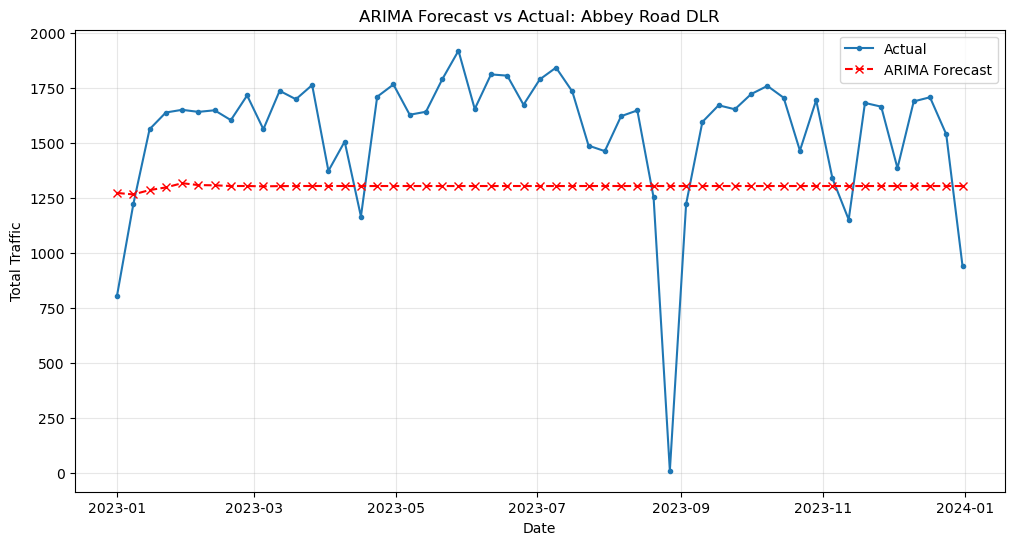

In [55]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings for cleaner output (ARIMA can be chatty with convergence warnings)
warnings.filterwarnings("ignore")

print("Starting ARIMA training for all stations (Baseline Model)...")

arima_preds = []
arima_targets = []
station_r2_scores = {}
station_mape_scores = {}

# Iterate over all stations to train univariate ARIMA models
# This serves as a baseline to compare with the GCN-LSTM model
for i, station in enumerate(common_stations):
    # Get train/test series for this station (using original unscaled data)
    train_series = train_data[station]
    test_series = test_data[station]
    
    try:
        # Fit ARIMA model
        # Order (5, 1, 0) assumes some autoregressive dependency on the past 5 weeks
        # and differencing once for stationarity.
        model_arima = ARIMA(train_series, order=(5, 1, 0)) 
        model_fit = model_arima.fit()
        
        # Forecast for the length of the test set
        forecast_result = model_fit.forecast(steps=len(test_series))
        forecast = forecast_result.values
        
        arima_preds.append(forecast)
        arima_targets.append(test_series.values)
        
        # Calculate individual station R2
        r2 = r2_score(test_series.values, forecast)
        station_r2_scores[station] = r2

        # Calculate individual station MAPE
        # Handle division by zero
        mask_st = test_series.values != 0
        if np.sum(mask_st) > 0:
            mape_st = np.mean(np.abs((test_series.values[mask_st] - forecast[mask_st]) / test_series.values[mask_st])) * 100
        else:
            mape_st = np.nan
        station_mape_scores[station] = mape_st
        
    except Exception as e:
        print(f"Failed for station {station}: {e}")
        # Append zeros or mean if failed to keep shapes consistent
        arima_preds.append(np.zeros(len(test_series)))
        arima_targets.append(test_series.values)
        station_mape_scores[station] = np.nan

    if (i + 1) % 50 == 0:
        print(f"Processed {i + 1}/{len(common_stations)} stations...")

# Convert to numpy arrays for global metric calculation
# Shape: [num_stations, time_steps] -> Transpose to [time_steps, num_stations]
arima_preds_np = np.array(arima_preds).T 
arima_targets_np = np.array(arima_targets).T

# Calculate global metrics
global_mse_arima = mean_squared_error(arima_targets_np, arima_preds_np)
global_mae_arima = mean_absolute_error(arima_targets_np, arima_preds_np)
global_r2_arima = r2_score(arima_targets_np.flatten(), arima_preds_np.flatten())

# Calculate Global MAPE (Micro-average)
# Handle division by zero: mask out zero values
mask = arima_targets_np != 0
global_mape_arima = np.mean(np.abs((arima_targets_np[mask] - arima_preds_np[mask]) / arima_targets_np[mask])) * 10

print("-" * 30)
print(f"Global ARIMA MSE: {global_mse_arima:.4f}")
print(f"Global ARIMA MAE: {global_mae_arima:.4f}")
print(f"Global ARIMA R2 Score: {global_r2_arima:.4f}")
print(f"Global ARIMA MAPE: {global_mape_arima:.4f}%")
print("-" * 30)

# --- Average MAPE per LSOA (or Area) ---
# Create DataFrame with Station MAPE
mape_df = pd.DataFrame(list(station_mape_scores.items()), columns=['Station', 'MAPE'])

# Merge with df_coords to get address (df_coords index is Station)
mape_df = mape_df.set_index('Station').join(df_coords[['address']])

# Helper to extract potential area/LSOA from address
# Heuristic: Extract 'London Borough of ...' or similar if LSOA not explicitly present
def extract_area(address):
    if not isinstance(address, str):
        return 'Unknown'
    parts = address.split(',')
    for part in parts:
        if 'Borough' in part:
            return part.strip()
    # Fallback: Extract postcode district (e.g., E15) could be a proxy
    # part = parts[-2].strip() # Assuming format ... Postcode, Country
    return 'Unknown' # Or use parsed postcode

mape_df['Area'] = mape_df['address'].apply(extract_area)

# Calculate Average MAPE per Area
# Drop NaNs
mape_df_clean = mape_df.dropna(subset=['MAPE'])
area_mape = mape_df_clean.groupby('Area')['MAPE'].mean().sort_values()

print("\nAverage MAPE by Area (Proxy for LSOA):")


# --- Visualization for the same sample station ---
# Using the same station_idx as the previous cell for direct comparison
station_idx = 0 
station_name = common_stations[station_idx]

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data[station_name], label='Actual', marker='.')
plt.plot(test_data.index, arima_preds_np[:, station_idx], label='ARIMA Forecast', linestyle='--', marker='x', color='red')
plt.title(f'ARIMA Forecast vs Actual: {station_name}')
plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

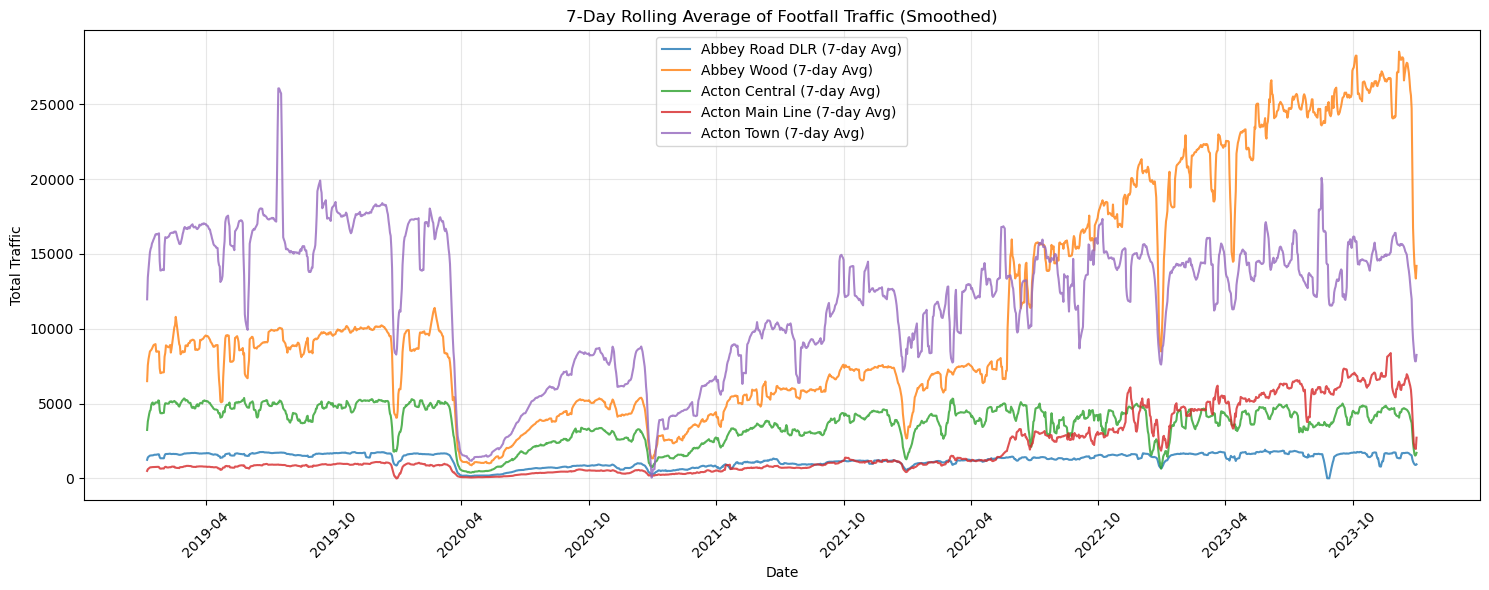

In [53]:
# Convert index to datetime if it's not already (for better plotting)
if not isinstance(df_pivot.index, pd.DatetimeIndex):
    df_pivot.index = pd.to_datetime(df_pivot.index)

# Calculate 7-day rolling average to smooth out weekly fluctuations
df_rolling = df_pivot.rolling(window=7).mean()

# Define stations to plot (e.g., first 5 stations)
stations_to_plot = df_pivot.columns[:5]

plt.figure(figsize=(15, 6))
for station in stations_to_plot:
    plt.plot(df_rolling.index, df_rolling[station], label=f'{station} (7-day Avg)', alpha=0.8)

plt.title('7-Day Rolling Average of Footfall Traffic (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.legend()
plt.grid(True, alpha=0.3)

# Use DateFormatter for better x-axis labels
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) # Show label every 6 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()